# Imports

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Cm for figures
cm = 1/2.54

# Load Data

In [2]:
df = pd.read_csv(os.path.join('data', 'pre_and_manifest.csv'))
df_filt = pd.read_csv(os.path.join('data', 'filtered_pre_and_manifest.csv'))
df_imp = pd.read_csv(os.path.join('data', 'imputed_pre_and_manifest.csv'))

# Dropped variables missing %

In [3]:
missing_post = (df.isnull().sum() / df.shape[0]) * 100
missing_post[list(set(df) - set(df_filt))].reset_index()\
                                          .rename(columns={'index': 'variable', 0: 'missing (%)'})\
                                          .sort_values('missing (%)', ascending=False)\
                                          .to_csv(os.path.join('additional_files', 'Additional file 1.csv'),
                                                  index=False, float_format='%.2f'
                                                 )

# Imputation

In [4]:
metrics = ['score', 'mae', 'rmse']

# Load results and get mean metrics for each variable + model
train_results1 = pd.read_csv(os.path.join('tables', 'impute_train_1.csv'))\
                   .groupby(['variable', 'problem', 'model'])[metrics].mean().reset_index()
test_results1 = pd.read_csv(os.path.join('tables', 'impute_test_1.csv'))\
                  .groupby(['variable', 'problem', 'model'])[metrics].mean().reset_index()

train_results2 = pd.read_csv(os.path.join('tables', 'impute_train_2.csv'))\
                   .groupby(['variable', 'problem', 'model'])[metrics].mean().reset_index()
test_results2 = pd.read_csv(os.path.join('tables', 'impute_test_2.csv'))\
                  .groupby(['variable', 'problem', 'model'])[metrics].mean().reset_index()

best_models = pd.read_csv(os.path.join('tables', 'best_models.csv'))

# Get best models from round1
r1 = pd.merge(best_models.loc[best_models['round'] == 1], test_results1, on=['variable', 'model'], how='left')
# Get best models from round2
r2 = pd.merge(best_models.loc[best_models['round'] == 2], test_results2, on=['variable', 'model'], how='left')

# Combine results with the given best models
best_models_results = pd.concat([r1, r2]).sort_values('score').reset_index(drop=True)
best_models_results = best_models_results.loc[~best_models_results['variable'].isin(['sbh1n', 'sbh3n', 'sbh4n'])]
best_models_results['problem'] = best_models_results['problem'].replace({'reg': 'Regression',
                                                                         'class': 'Classification',
                                                                         'ordinal': 'Ordinal Regression',
                                                                        })
best_models_results['model'] = best_models_results['model'].replace({'knn': 'Knn',
                                                                     'lin': 'Linear',
                                                                     'tree': 'RF',
                                                                    })
best_models_results['model'].value_counts()

RF        121
Linear     36
Knn         3
Name: model, dtype: int64

In [5]:
def sorter(column):
    reorder = ['RF', 'Linear', 'Knn']
    # This also works:
    # mapper = {name: order for order, name in enumerate(reorder)}
    # return column.map(mapper)
    cat = pd.Categorical(column, categories=reorder, ordered=True)
    return pd.Series(cat)

Regression mean score: 0.531
samples with R2 > 0.6 37 / 59
Ordinal Regression mean score: 0.735
samples with F1 > 0.7 43 / 76
Classification mean score: 0.914
samples with F1 > 0.7 25 / 25


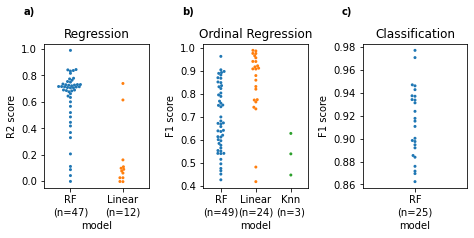

In [6]:
from matplotlib.lines import Line2D
# sns.catplot(x='model', y='score', hue='round', col='problem', kind='swarm', data=best_models_results)
# width : 0 -  8.5 - 17
# height: 0 - 22.5
chars = ['a)', 'b)', 'c)']

fig, axs = plt.subplots(1, 3, figsize=(17*cm, 9*cm), sharey=False)
for i, prob, ax in zip(range(3), best_models_results['problem'].unique(), axs):
    subset = best_models_results.loc[best_models_results['problem']==prob]\
                                .sort_values(by="model", key=sorter)
    print('{} mean score: {:.3f}'.format(prob, subset.score.mean()))
    # sns.boxplot(x='model', y='score', hue='model', ax=ax, dodge=False, data=subset)
    sns.swarmplot(x='model', y='score', hue='model', size=3, ax=ax, dodge=False, data=subset)

    if prob == 'Regression':
        print('samples with R2 > 0.6', np.sum(subset['score'] > 0.6), '/', subset.shape[0])
    elif prob == 'Ordinal Regression' or prob == 'Classification':
        print('samples with F1 > 0.7', np.sum(subset['score'] > 0.7), '/', subset.shape[0])

    # Plotting
    ax.set_title(prob)
    ax.legend().remove()
    if i > 0:
        ax.set_ylabel('F1 score')
    else:
        ax.set_ylabel('R2 score')
    
    ax.text(-0.2, 1.2, chars[i], transform=ax.transAxes, 
            size=10, weight='bold')
    new_labels = []
    for lab in ax.get_xticklabels():
        txt = lab.get_text()
        n = np.sum((best_models_results['problem']==prob) & (best_models_results['model']==txt))
        new_labels.append('{}\n(n={})'.format(txt, n))
    ax.set_xticklabels(new_labels)
    
plt.tight_layout()
plt.savefig('output/figures/figure3.pdf', dpi=300, pad_inches=0, bbox_inches="tight")

# Completeness

In [7]:
def form(v):
    if v in ['motscore', 'miscore', 
             'ocularh', 'ocularv', 'sacinith', 'sacinitv', 'sacvelh', 'sacvelv', 'dysarth', 'tongue', 'fingtapr',
             'fingtapl', 'prosupr', 'prosupl', 'luria', 'rigarmr', 'rigarml', 'brady', 'dysttrnk', 'dystrue',
             'dystlue', 'dystrle', 'dystlle', 'chorface', 'chorbol', 'chortrnk', 'chorrue', 'chorlue', 'chorrle',
             'chorlle', 'gait', 'tandem', 'retropls', 'diagconf']:
        return 'Motor'
    elif v in ['tfcscore', 'occupatn', 'finances', 'chores', 'adl', 'carelevl']:
        return 'TFC'
    elif v in ['fascore', 'fiscore',
               'emplusl', 'emplany', 'volunt', 'fafinan', 'grocery', 'cash', 'supchild', 'drive', 'housewrk', 'laundry',
               'prepmeal', 'telephon', 'ownmeds', 'feedself', 'dress', 'bathe', 'pubtrans', 'walknbr', 'walkfall',
               'walkhelp', 'comb', 'trnchair', 'bed', 'toilet', 'carehome', 'indepscl']:
        return 'Function'
    elif v in ['depscore', 'irascore', 'psyscore', 'aptscore', 'exfscore', 'pbas1sv', 'pbas1fr', 'pbas1wo', 'pbas2sv',
               'pbas2fr', 'pbas2wo', 'pbas3sv', 'pbas3fr', 'pbas3wo', 'pbas4sv', 'pbas4fr', 'pbas4wo', 'pbas5sv',
               'pbas5fr', 'pbas5wo', 'pbas6sv', 'pbas6fr', 'pbas6wo', 'pbas7sv', 'pbas7fr', 'pbas7wo', 'pbas8sv',
               'pbas8fr', 'pbas8wo', 'pbas9sv', 'pbas9fr', 'pbas9wo', 'pbas10sv', 'pbas10sm__1', 'pbas10sm__2',
               'pbas10sm__3', 'pbas10sm__4', 'pbas10sm__5', 'pbas10fr', 'pbas10wo', 'pbas11sv', 'pbas11fr', 'pbas11wo',
               'pbainfo', 'pbahshd']:
        return 'PBA-S'
    elif v in ['hxalcab', 'hxtobab', 'hxtobcpd', 'hxtobyos', 'hxpacky', 'hxdrugab', 'hxmar', 'hxmarfrq', 'hxher',
               'hxherfrq', 'hxcoc', 'hxcocfrq', 'hxclb', 'hxclbfrq', 'hxamp', 'hxampfrq', 'hxrit', 'hxritfrq', 'hxhal',
               'hxhalfrq', 'hxinh', 'hxinhfrq', 'hxopi', 'hxopifrq', 'hxpak', 'hxpakfrq', 'hxbar', 'hxbarfrq', 'hxtrq',
               'hxtrqfrq']:
        return 'MHx'
    elif v in ['height', 'weight', 'bmi', 'hdcat',
               'alcab', 'alcunits', 'tobab', 'tobcpd', 'tobyos', 'packy', 'cafab', 'cafpd', 'drugab', 'mar', 'marfrq',
               'her', 'herfrq', 'coc', 'cocfrq', 'clb', 'clbfrq', 'amp', 'ampfrq', 'rit', 'ritfrq', 'hal', 'halfrq',
               'inh', 'inhfrq', 'opi', 'opifrq', 'pak', 'pakfrq', 'bar', 'barfrq', 'trq', 'trqfrq']:
        return 'Var Items I'
    elif v in ['updsc', 'maristat', 'res', 'isced', 'jobclas', 'jobpaid',
               'rdcwk', 'rdcwkd', 'rdcwkhw', # Baseline
               'emplnrsn', 'emplnrd', 'ssdb', 'rtrnwk', 'rtrddur']:
        return 'Var Items II'
    elif v in ['gen1', 'gen2', 'gen3', 'gen4', 'gen5', 'gen6', 'sdmt', 'sdmt1', 'sdmt2', 'sdmtnd', 'verfct', 'verfctd',
               'verfct5', 'verfct6', 'verfct7', 'verfctnd', 'scnt', 'scnt1', 'scnt2', 'scnt3','scntnd', 'swrt', 'swrt1',
               'swrt2', 'swrt3', 'swrtnd', 'sit', 'sit1', 'sit2', 'sit3', 'trl', 'trla1', 'trla2', 'trla3', 'trlb1',
               'trlb2', 'trlb3', 'verflt', 'verflt05', 'verflt06', 'verflt07']:
        return 'Cognitive'
    elif v == 'mmsetotal':
        return 'MMSE'
    elif v in ['tug', 'tug1', 'scst', 'scst1']:
        return 'Physiotherapy'
    elif v in ['wpaiscr1', 'wpaiscr2', 'wpaiscr3', 'wpaiscr4']:
        return 'WPAI-SHP'
    elif v in ['scoring', 'pf', 'rp', 'bp', 'gh', 'vt', 'sf', 're', 'mh', 'pcs', 'mcs']:
        return 'SF-12'
    elif v in ['anxscore', 'hads_depscore', 'irrscore', 'outscore', 'inwscore']:
        return 'HADS-SIS'
    elif v in ['region', 'sex', 'race', 'handed', 'hxsid', 'dssage', 'dsplace', 'dsend', 'caghigh', 'caglow',
               'momhd', 'momagesx', 'dadhd', 'dadagesx', 'fhx',
               'ccmtr', 'ccmtrage', 'sxsubj', 'sxsubjm', 'sxs_m', 'sxs_c', 'sxs_p', 'sxs_o', 'sxfam',
               'sxfamm', 'sxf_m', 'sxf_c', 'sxf_p', 'sxf_o', 'hddiagn', 'sxest', 'sxrater', 'sxestcfd', 'sxreas', 'sxgs',
               'sxraterm', 'sxr_m', 'sxr_c', 'sxr_p', 'sxr_o', 'ccdep', 'ccdepage', 'ccirb', 'ccirbage',
               'ccvab', 'ccvabage', 'ccapt', 'ccaptage', 'ccpob', 'ccpobage', 'ccpsy', 'ccpsyage', 'ccpsyfh', 'cccog',
               'cccogage', 'xgwas', 'xbsp', 'xpheno', 'xmorpho', 'ximage']:
        return 'Profile'
    elif v in ['sid1', 'sid2', 'sid3', 'sid4', 'sid5', 'int1', 'int2', 'int3', 'int4', 'int5', 'int6', 'sbh1', 'sbh1n',
               'sbh2', 'sbh3', 'sbh3n', 'sbh4', 'sbh4n', 'sbh5', 'sbh6', 'sbh7']:
        return 'C-SSRS'
    else:
        return 'null'

In [12]:
def completeness(preprocessed_data, original_data):
    rows = preprocessed_data.shape[0]
    rows2 = original_data.shape[0]
        
    preprocessed_data = preprocessed_data.isnull().sum().reset_index()
    preprocessed_data.columns = ['variable', 'missing']
    
    original_data = original_data.isnull().sum().reset_index()
    original_data.columns = ['variable', 'missing']

    g1 = preprocessed_data['variable'].apply(lambda x: form(x) if form(x) !='null' else form(x.split('_')[0])) 
    preprocessed_data['group'] = g1.astype(str)
    
    g2 = original_data['variable'].apply(lambda x: form(x) if form(x) !='null' else form(x.split('_')[0])) 
    original_data['group'] = g2.astype(str)

    preprocessed_data = preprocessed_data.groupby('group').missing.aggregate(['sum', 'count']) # .sort_values('mean')
    original_data = original_data.groupby('group').missing.aggregate(['sum', 'count']) # .sort_values('mean')

    
    
    cm = 1/2.54
    plt.figure(figsize=(17*cm, 10*cm))
    w = .3
    plt.xticks(rotation=90)
    forms = ['Profile', 'MHx', 'Var Items I', 'Var Items II', 'Motor', 'Function', 'TFC',
             'Cognitive', 'MMSE', 'Physiotherapy', 'PBA-S', 'SF-12', 'HADS-SIS', 'WPAI-SHP', 'C-SSRS']
    
    for i, g in enumerate(forms):
        if g in preprocessed_data.index:
            p1 = plt.bar(x=i,
                         height=100 * (1 - (preprocessed_data.loc[g,'sum'] / (rows * preprocessed_data.loc[g,'count']) )),
                         # yerr=preprocessed_data.loc[g,'std'],
                         width=w,
                         color='C0',
                         label='Pre-Processed',
                        )
        else:
            p1 = plt.bar(x=i,
                         height=0.0,
                         #yerr=0.0,
                         width=w,
                         color='C0',
                         label='Pre-Processed',
                        )
        if g in original_data.index:
            p2 = plt.bar(x=i+w,
                         height=100 * (1 - (original_data.loc[g,'sum'] / (rows2 * original_data.loc[g,'count']))),
                         # yerr=original_data.loc[g,'std'],
                         width=w,
                         color='C1',
                         label='Original',
                        )
        else:
            p2 = plt.bar(x=i,
                         height=0.0,
                         #yerr=0.0,
                         width=w,
                         color='C0',
                         label='Original',
                        )
    plt.legend([p1, p2], ['Pre-Processed', 'Original'], ncol=2,
                bbox_to_anchor=(0., 1.02, 1., .102), loc=8, borderaxespad=0.)
    plt.xticks([i + w*.5 for i in range(len(forms))], forms)
    
    plt.ylim(0, 105)
    j = -.3

    plt.ylabel('Completeness %')
    plt.xlabel('Form')

    plt.tight_layout()
    plt.savefig('output/figures/figure2.pdf', dpi=300, bbox_inches="tight", pad_inches=0)

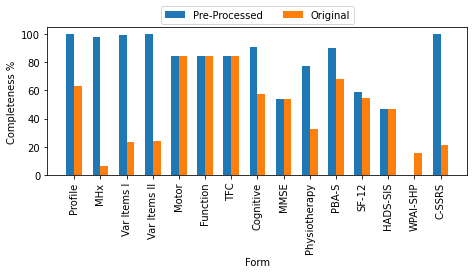

In [13]:
completeness(df_filt.copy(), df.copy())